In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
from scipy.stats import beta

In [4]:
import itertools

In [5]:
p = {1: 0.2, 
     2: 0.5, 
     3: 0.45, 
     4: 0.3, 
     5: 0.1, 
     6: 0.45
    }

In [6]:
N = 6000

Exercise 1

a)

We use a flat prior for the probability $\gamma$ of success, which could be described as a Beta(1,1) prior. Since the beta distribution is the conjugate of the Bernoulli distributions, the posterior should also be beta. Assuming we observe $N_0$ fails and $N_1$ successes, the posterior is:

$$p(\gamma|Y) = p(Y|\gamma) P (\gamma) / P(Y)$$
$$p(\gamma|Y) = \frac{{N \choose N_1}\gamma^{N_1}(1-\gamma)^{N_0} P (\gamma)}{P(Y)}$$
$$p(\gamma|Y) = \frac{{N \choose N_1}\gamma^{N_1}(1-\gamma)^{N_0} P (\gamma)}{\int_{0}^{1} {N \choose N_1}\gamma^{N_1}(1-\gamma)^{N_0} P (\gamma) d\gamma}$$
$$\gamma|Y \sim Beta(1 + N_1,1 + N_0)$$

In [7]:
def get_post(results):
    mean = {}
    var = {}
    post_beta = {}
    for i in results.keys():
        if len(results[i]) == 0:
            N_1 = 1
            N_0 = 1
        else:
            N_1 = int((np.sum(results[i])))
            N_0 = int(len(results[i]) - N_1)
        post_beta[i] = [N_1 + 1, N_0 + 1]
        mean[i] = (N_1 + 1) / (N_0 + 1 + N_1 + 1)
        var[i] = (N_0 + 1) * (N_1 + 1) / ((N_0 + 1 + N_1 + 1) ** 2 * (N_0 + 1 + N_1 + 1 + 1))

    return post_beta, mean, var


In [8]:
def get_points(n_points, post_beta):
    
    points = np.linspace(0,1, n_points)
    # Getting all the CDF for each arm:
    cdf_beta = {}
    pdf_beta = {}
    for x in post_beta.keys():
        cdf_beta[x] = beta.cdf(points, post_beta[x][0], post_beta[x][1])
        pdf_beta[x] = beta.pdf(points, post_beta[x][0], post_beta[x][1])
        
    return points, cdf_beta, pdf_beta

In [9]:
def get_p_max(post_beta, n_points):
    
    prob_max = {}
    points, cdf_beta, pdf_beta = get_points(n_points, post_beta)
    
    for arm in post_beta.keys():
    
        prob = 0
        for i, _ in enumerate(points[:-1]):
            p_max_a = 1
            p_max_b = 1
            
            for other_arm in post_beta.keys():
                if other_arm != arm:
                    p_max_a = p_max_a * cdf_beta[other_arm][i]
                    p_max_b = p_max_b * cdf_beta[other_arm][i + 1]

            p_max_a = p_max_a * (pdf_beta[arm][i])
            p_max_b = p_max_b * (pdf_beta[arm][i + 1])
            prob += (p_max_a + p_max_b)/2 * ( points[i + 1] - points[i])
        
    
        prob_max[arm] = prob
    return pd.Series(prob_max)/pd.Series(prob_max).sum()

In [10]:
class RandomExperiment:
    def __init__(self, N,p_arms, n_points = 1000):
        self.N = N
        self.p = p_arms
        self.results = {}
        self.post_beta = {}
        self.n_points = n_points
        for i in p.keys():
            self.results[i] = []
            
    
    def sample(self):
        n_per_arm = int(np.floor(self.N / len(self.p.keys())))
        for _ in range(n_per_arm):
            for i in self.p.keys():
                self.results[i].append(np.random.choice([0,1], p = [1-self.p[i], self.p[i]]))
        self.post_beta, self.mean, self.var = get_post(self.results)
        self.prob_max = get_p_max(self.post_beta, self.n_points)
        self.counts = dict(zip(self.results.keys(), [*map(len, self.results.values())]))
        self.highest_prob_max = self.prob_max.idxmax()
        self.highest_mean = pd.Series(self.mean).idxmax()
        self.regret = max(self.p.values()) - np.mean(list(itertools.chain.from_iterable(self.results.values())))

In [11]:
r0 = RandomExperiment(N = 6000, p_arms=p)

In [12]:
r0.sample()

In [13]:
r0.mean

{1: 0.21057884231536927,
 2: 0.5059880239520959,
 3: 0.45808383233532934,
 4: 0.2954091816367265,
 5: 0.09580838323353294,
 6: 0.4431137724550898}

In [14]:
r0.var

{1: 0.00016573817894764519,
 2: 0.00024921649408688845,
 3: 0.0002475005332884419,
 4: 0.00020752003693065408,
 5: 8.637002685514399e-05,
 6: 0.0002460258794772769}

In [15]:
n_points = 1000

In [16]:
r0.post_beta

{1: [211, 791],
 2: [507, 495],
 3: [459, 543],
 4: [296, 706],
 5: [96, 906],
 6: [444, 558]}

In [17]:
points, cdf_beta, pdf_beta = get_points(1000, r0.post_beta )

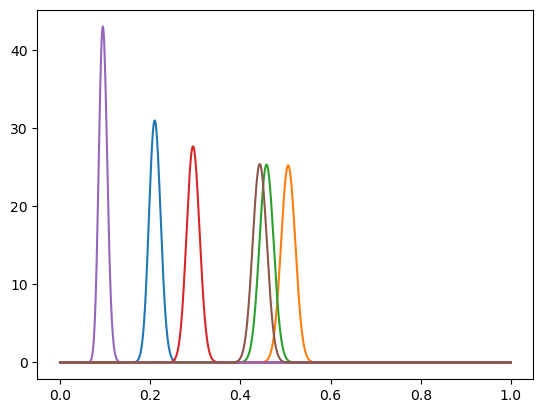

In [18]:
plt.plot(points, pdf_beta[1])
plt.plot(points, pdf_beta[2])
plt.plot(points, pdf_beta[3])
plt.plot(points, pdf_beta[4])
plt.plot(points, pdf_beta[5])
plt.plot(points, pdf_beta[6])

b)

In [19]:
r0.prob_max

1     3.914125e-54
2     9.823156e-01
3     1.566047e-02
4     4.485701e-26
5    5.077609e-119
6     2.023947e-03
dtype: float64

c)

In [20]:
class ThomsonExperiment:
    def __init__(self, N,p_arms, n_trials = 100, n_points = 1000):
        self.N = N
        self.p = p_arms
        self.results = {}
        self.post_beta = {}
        self.n_trials = n_trials
        self.n_points = n_points
        for i in p.keys():
            self.results[i] = []
            # Initializing a flat prior
            self.post_beta[i] = [1,1]

        self.n_update = int(np.floor(N/n_trials))
            
    
    def sample(self):
        for _ in range(self.n_update):
            self.prob_max = get_p_max(self.post_beta, self.n_points)
            for _ in range(self.n_trials):
                i = np.random.choice(self.prob_max.index, p = self.prob_max.values )
                self.results[i].append(np.random.choice([0,1], p = [1-self.p[i], self.p[i]]))
            self.post_beta, self.mean, self.var = get_post(self.results)
        self.counts = dict(zip(self.results.keys(), [*map(len, self.results.values())]))
        self.highest_prob_max = self.prob_max.idxmax()
        self.highest_mean = pd.Series(self.mean).idxmax()
        self.regret = max(self.p.values()) - np.mean(list(itertools.chain.from_iterable(self.results.values())))

In [21]:
t0 = ThomsonExperiment(N, p)

In [22]:
t0.sample()

In [23]:
points, cdf_beta_thomson, pdf_beta_thomson = get_points(n_points, t0.post_beta)

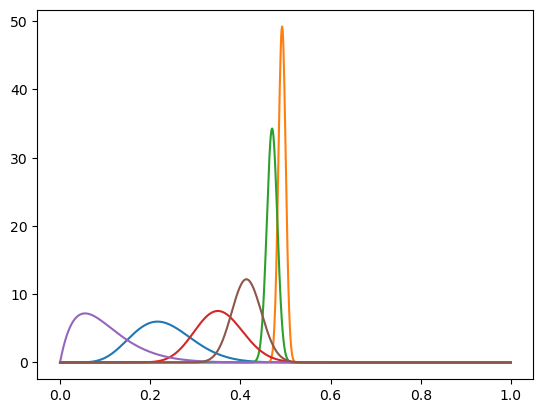

In [24]:
plt.plot(points, pdf_beta_thomson[1])
plt.plot(points, pdf_beta_thomson[2])
plt.plot(points, pdf_beta_thomson[3])
plt.plot(points, pdf_beta_thomson[4])
plt.plot(points, pdf_beta_thomson[5])
plt.plot(points, pdf_beta_thomson[6])

In [25]:
t0.mean

{1: 0.23076923076923078,
 2: 0.49250985545335085,
 3: 0.4703643284393692,
 4: 0.35365853658536583,
 5: 0.1,
 6: 0.41409691629955947}

In [26]:
t0.var

{1: 0.004437869822485207,
 2: 6.567101884778515e-05,
 3: 0.0001353922429191035,
 4: 0.002754026217899558,
 5: 0.004285714285714286,
 6: 0.0010641257026787504}

In [27]:
t0.prob_max

1    0.000354
2    0.911609
3    0.069469
4    0.007720
5    0.000051
6    0.010797
dtype: float64

In [28]:
pd.Series(t0.counts)/pd.Series(t0.counts).sum()

1    0.006167
2    0.633833
3    0.306167
4    0.013333
5    0.003000
6    0.037500
dtype: float64

d)

Running every approach 100 times

In [29]:
n_rep = 100

In [30]:
list_random = [RandomExperiment(N, p) for _ in range(n_rep)]
list_thomsom = [ThomsonExperiment(N, p) for _ in range(n_rep)]

In [31]:
[mod.sample() for mod in list_random]
[mod.sample() for mod in list_thomsom]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [32]:
max_mean_arm_r = [mod.highest_mean for mod in list_random]
max_prob_arm_r = [mod.highest_prob_max for mod in list_random]

In [33]:
max_mean_arm_t = [mod.highest_mean for mod in list_thomsom]
max_prob_arm_t = [mod.highest_prob_max for mod in list_thomsom]

Random

In [34]:
pd.Series(max_mean_arm_r).value_counts()

2    100
Name: count, dtype: int64

In [35]:
pd.Series(max_prob_arm_r).value_counts()

2    100
Name: count, dtype: int64

Thomson

In [36]:
pd.Series(max_mean_arm_t).value_counts()

2    99
6     1
Name: count, dtype: int64

In [37]:
pd.Series(max_prob_arm_t).value_counts()

2    99
6     1
Name: count, dtype: int64

e)

In [38]:
regret_r = [mod.regret for mod in list_random]
regret_t = [mod.regret for mod in list_thomsom]

In [39]:
np.mean(regret_r)

0.16661833333333334

In [40]:
np.mean(regret_t)

0.011958333333333335